<a href="https://colab.research.google.com/github/ladofa/edu/blob/master/Example_classification_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip

--2021-12-27 06:30:04--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.61.16
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.61.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95592747 (91M) [application/octet-stream]
Saving to: ‘4drtyfjtfy-1.zip’

4drtyfjtfy-1.zip    100%[===================>]  91.16M  49.9MB/s    in 1.8s    

2021-12-27 06:30:06 (49.9 MB/s) - ‘4drtyfjtfy-1.zip’ saved [95592747/95592747]



In [2]:
!unzip -qq 4drtyfjtfy-1.zip 
!unzip -qq dataset2.zip


In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import random
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [4]:
!mkdir new_dataset

In [5]:
path_label = []

labels = ['cloudy', 'rain', 'sunrise', 'shine']
for root, dirs, filenames in os.walk('dataset2'):
    for filename in filenames:
        label = -1
        
        for index, label_name in enumerate(labels):
            if label_name in filename:
                label = index
                break

        if label == -1:
            continue

        path = os.path.join(root, filename)
        image = cv2.imread(path)
        if image is None:
            print('failed : ', path)
            continue
        try:
            first, last = os.path.splitext(filename)
            new_path = os.path.join('new_dataset', first + '.jpg')
            cv2.imwrite(new_path, image)
            path_label.append((new_path, label))
        except:
            print(filename)
            continue

failed :  dataset2/shine131.jpg
failed :  dataset2/rain141.jpg


In [6]:
len(path_label)

1123

In [7]:
path_label[:10]

[('new_dataset/cloudy33.jpg', 0),
 ('new_dataset/cloudy292.jpg', 0),
 ('new_dataset/shine5.jpg', 3),
 ('new_dataset/sunrise302.jpg', 2),
 ('new_dataset/cloudy281.jpg', 0),
 ('new_dataset/shine92.jpg', 3),
 ('new_dataset/shine13.jpg', 3),
 ('new_dataset/cloudy75.jpg', 0),
 ('new_dataset/cloudy235.jpg', 0),
 ('new_dataset/shine20.jpg', 3)]

In [8]:
path_label_train = []
path_label_valid = []
random.shuffle(path_label)

for item in path_label:
    if random.random() < 0.9:
        path_label_train.append(item)
    else:
        path_label_valid.append(item)

In [9]:
def generator_train():
    for path, label in path_label_train:
        yield path, label

def generator_valid():
    for path, label in path_label_valid:
        yield path, label

In [10]:
dataset_train = tf.data.Dataset.from_generator(
    generator_train,
    (tf.string, tf.int64),
    ([], [])
)

dataset_valid = tf.data.Dataset.from_generator(
    generator_valid,
    (tf.string, tf.int64),
    ([], [])
)

def load_image(path, label):
    bin = tf.io.read_file(path)
    image = tf.image.decode_jpeg(bin)
    return image, label

dataset_train = dataset_train.map(load_image, num_parallel_calls=-1)
dataset_valid = dataset_valid.map(load_image, num_parallel_calls=-1)

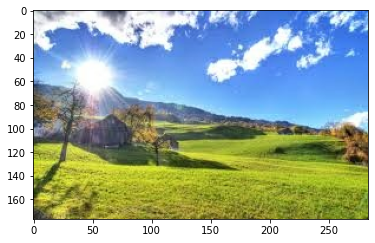

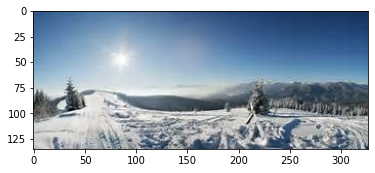

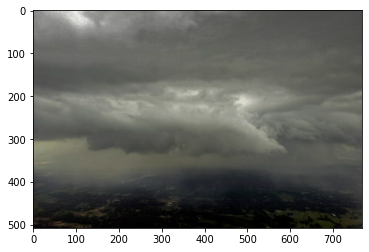

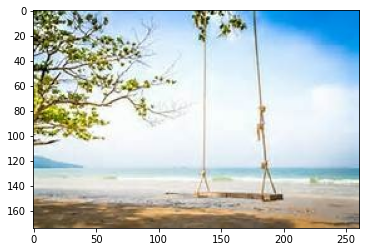

In [11]:
for image, label in dataset_train.take(4):
    plt.imshow(image)
    plt.show()


In [12]:
import random

def random_geometry(image, target_size):
    height, width, _ = image.shape
    #기본 위치
    x0 = 0
    y0 = 0
    x1 = width
    y1 = height

    #-- 크롭
    x0 = x0 + random.randint(0, int(width * 0.15))
    y0 = y0 + random.randint(0, int(height * 0.15))
    x1 = x1 - random.randint(0, int(width * 0.15))
    y1 = y1 - random.randint(0, int(height * 0.15))

    #--코너점
    corners = np.array(
        [
            [x0, y0, 1],
            [x1, y0, 1],
            [x1, y1, 1],
            [x0, y1, 1]
        ], dtype=np.float32)

    #-- 회전 + (스케일)
    aug_angle = random.uniform(-30, 30)
    #ori_width is center of nu_image
    rot_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), aug_angle, 1.0).astype(np.float32)
    corners = corners @ rot_matrix.T

    #-- 랜덤 추가
    corners += np.random.randn(4, 2) * (width * 0.01)

    #-- 호모그래피
    tw, th = target_size
    target_corners = np.array(
        [
            [0, 0],
            [tw, 0],
            [tw, th],
            [0, th]
        ], dtype=np.float32)
    h = cv2.getPerspectiveTransform(corners, target_corners)
    dst = cv2.warpPerspective(image, h, target_size)
    return dst
    
def random_salt_and_papper(image):
    #salt and papper
    height, width, _ = image.shape
    
    salts = [[0, 0, 0], [255, 255, 255], [0, 0, 255], [0, 255, 0], [255, 0, 0]]

    for salt in salts:
        if random.random() < 0.1:
            salt_count = int(width * height * 0.01 * random.random())
            y_coord = np.random.randint(0, height, [salt_count])
            x_coord = np.random.randint(0, width, [salt_count])
            image[y_coord, x_coord] = salt

def random_blur_or_shappen(image):
    blured = cv2.GaussianBlur(image, (5, 5), 7)
    weight = np.array(-0.7 + random.random() * 1.4, dtype=np.float32)
    image = image * (1 - weight) + blured * weight
    return image  


def random_flip(image):
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
    return image

def random_lines(image):
    for ch in range(0, 2):
        if random.random() < 0.05:
            step = random.randint(3, 7)
            start = random.randint(0, step - 1)
            image[start::step, :, ch] = random.randint(0, 255)

    for ch in range(0, 2):
        if random.random() < 0.05:
            step = random.randint(3, 7)
            start = random.randint(0, step - 1)
            image[:, start::step, ch] = random.randint(0, 255)

def random_dim(image):
    image = np.random.randint(low=-10, high=10, size=(3))
    image *= random.random() * 0.2 + 0.9
    image += random.randint(-10, 10)
    

def random_ditter(image):
    if random.random() < 0.5:
        image += np.random.normal(0, random.randint(1, 20), image.shape)

def random_box(image):
    height, width, _ = image.shape
    cy = np.random.randint(0, height)
    cx = np.random.randint(0, width)

    bh = np.random.randint(10, height * 0.3) // 2
    bw = np.random.randint(10, width * 0.3) // 2
    y1 = cy - bh
    y2 = cy + bh
    x1 = cx - bw
    x2 = cx + bw

    image[y1:y2, x1:x2, :] = np.random.randint(0, 255, [3])


def random_multi_tone(image):
    if random.random() < 0.1:
        sep = random.randint(image.shape[1] // 4, image.shape[1] * 3 // 4)
        offset = (np.random.random([3]) - 0.5) * 30
        image[:, :sep, :] += offset
        offset = (np.random.random([3]) - 0.5) * 30
        image[:, sep:, :] += offset
    if random.random() < 0.1:
        sep = random.randint(image.shape[0] // 4, image.shape[0] * 3 // 4)
        offset = (np.random.random([3]) - 0.5) * 30
        image[:sep, :, :] += offset
        offset = (np.random.random([3]) - 0.5) * 30
        image[sep:, :, :] += offset

def random_shadow(image):
    width = image.shape[1]
    height = image.shape[0]

    ver_shadow = (np.arange(height) - (height / 2)) / (height / random.randint(1, 30))
    hor_shadow = (np.arange(width) - (width / 2)) / (width / random.randint(1, 30))

    ver_shadow = np.linspace(0, 1, height).reshape([-1, 1, 1]) - 0.5
    hor_shadow = np.linspace(0, 1, width).reshape([1, -1, 1]) - 0.5
    
    ver_shadow *= np.random.randn() * 40
    hor_shadow *= np.random.randn() * 40

    image += ver_shadow.astype(np.float32)
    image += hor_shadow.astype(np.float32)



In [13]:
def aug_all_numpy(image):
    image = random_geometry(image, target_size=(224, 224))
    # image = cv2.resize(image, (224, 224))
    image = random_flip(image)

    image = image.astype(np.float32)
    image = random_blur_or_shappen(image)
    # random_dim(image)
    random_ditter(image)
    # random_multi_tone(image)
    # random_shadow(image)

    image = np.clip(image, 0, 255)
    # random_lines(image)
    random_salt_and_papper(image)
    # random_box(image)
    return image


def aug_train(image, label):
    image = tf.numpy_function(aug_all_numpy, [image], tf.float32)
    image = keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def aug_valid(image, label):
    image = tf.image.resize(image, (224, 224))
    image = keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

In [14]:
dt = dataset_train.map(aug_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dv = dataset_valid.map(aug_valid, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dt = dt.repeat().shuffle(500).batch(32).prefetch(1)
dv = dv.batch(32).prefetch(1)

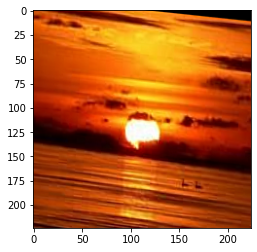

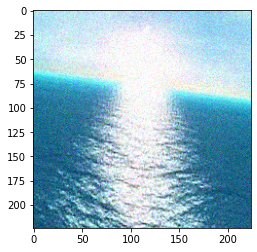

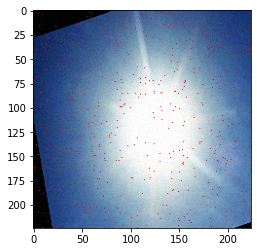

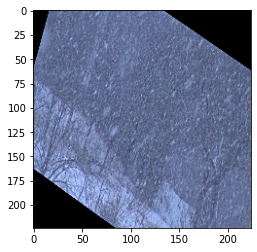

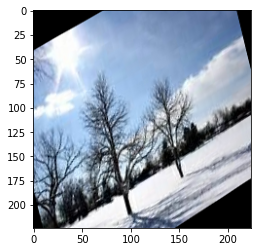

In [15]:
for item in dt.take(1):
    for i in range(5):
        plt.imshow(item[0][i] / 2 + 0.5)
        plt.show()

In [16]:
pre_model = keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape=[224, 224, 3], weights='imagenet')
pre_model.output

9420800/9406464 [==============================] - 0s 0us/step


<KerasTensor: shape=(None, 7, 7, 1280) dtype=float32 (created by layer 'out_relu')>

In [17]:
model = keras.models.Sequential([
    pre_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(4, activation='softmax')
])

pre_model.trainable = False

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
              metrics=['accuracy'])
model.fit(dt, epochs=5, steps_per_epoch=30, validation_data=dv)

Epoch 1/5
30/30 [==============================] - 22s 279ms/step - loss: 1.0534 - accuracy: 0.5667 - val_loss: 0.5788 - val_accuracy: 0.8175
Epoch 2/5
30/30 [==============================] - 7s 250ms/step - loss: 0.5060 - accuracy: 0.8354 - val_loss: 0.3665 - val_accuracy: 0.8905
Epoch 3/5
30/30 [==============================] - 7s 249ms/step - loss: 0.3676 - accuracy: 0.8823 - val_loss: 0.3026 - val_accuracy: 0.9197
Epoch 4/5
30/30 [==============================] - 8s 279ms/step - loss: 0.3293 - accuracy: 0.8917 - val_loss: 0.2873 - val_accuracy: 0.9343
Epoch 5/5
30/30 [==============================] - 7s 238ms/step - loss: 0.2863 - accuracy: 0.8979 - val_loss: 0.2868 - val_accuracy: 0.9197


In [20]:
model.fit(dt, epochs=10, steps_per_epoch=30, validation_data=dv)

Epoch 1/10
30/30 [==============================] - 10s 234ms/step - loss: 0.2651 - accuracy: 0.9115 - val_loss: 0.2294 - val_accuracy: 0.9197
Epoch 2/10
30/30 [==============================] - 7s 244ms/step - loss: 0.2611 - accuracy: 0.9062 - val_loss: 0.2562 - val_accuracy: 0.9270
Epoch 3/10
30/30 [==============================] - 7s 241ms/step - loss: 0.2258 - accuracy: 0.9271 - val_loss: 0.2372 - val_accuracy: 0.9270
Epoch 4/10
30/30 [==============================] - 7s 230ms/step - loss: 0.1969 - accuracy: 0.9406 - val_loss: 0.2081 - val_accuracy: 0.9197
Epoch 5/10
30/30 [==============================] - 7s 229ms/step - loss: 0.2103 - accuracy: 0.9250 - val_loss: 0.1857 - val_accuracy: 0.9416
Epoch 6/10
30/30 [==============================] - 7s 232ms/step - loss: 0.1842 - accuracy: 0.9365 - val_loss: 0.1990 - val_accuracy: 0.9270
Epoch 7/10
30/30 [==============================] - 7s 231ms/step - loss: 0.1825 - accuracy: 0.9354 - val_loss: 0.1851 - val_accuracy: 0.9343
Epoch

In [21]:
model.save('model1.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [22]:
pre_model.trainable = True
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics='accuracy')
model.fit(dt, epochs=10, steps_per_epoch=30, validation_data=dv)

Epoch 1/10
30/30 [==============================] - 25s 303ms/step - loss: 0.5673 - accuracy: 0.8406 - val_loss: 1.7937 - val_accuracy: 0.7226
Epoch 2/10
30/30 [==============================] - 8s 272ms/step - loss: 0.3075 - accuracy: 0.9073 - val_loss: 19.6018 - val_accuracy: 0.3869
Epoch 3/10
30/30 [==============================] - 8s 272ms/step - loss: 0.3267 - accuracy: 0.9083 - val_loss: 11.3801 - val_accuracy: 0.5474
Epoch 4/10
30/30 [==============================] - 8s 283ms/step - loss: 0.2213 - accuracy: 0.9323 - val_loss: 12.7188 - val_accuracy: 0.4234
Epoch 5/10
30/30 [==============================] - 8s 267ms/step - loss: 0.1391 - accuracy: 0.9458 - val_loss: 9.8202 - val_accuracy: 0.4015
Epoch 6/10
30/30 [==============================] - 8s 269ms/step - loss: 0.1193 - accuracy: 0.9573 - val_loss: 10.1603 - val_accuracy: 0.4964
Epoch 7/10
30/30 [==============================] - 8s 285ms/step - loss: 0.1788 - accuracy: 0.9344 - val_loss: 15.2147 - val_accuracy: 0.5036


In [23]:
model = keras.models.load_model('model1.h5')

In [24]:
y_pred = []
y_true = []

for images, labels, in dv:
    batch_y_pred = model.predict(images)
    y_pred.extend(batch_y_pred)
    y_true.extend(labels)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

In [25]:
from sklearn.metrics import confusion_matrix

y_pred = y_pred.argmax(axis=1)

In [26]:
y_pred == y_true

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [27]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[33,  0,  2,  4],
       [ 0, 27,  1,  0],
       [ 0,  0, 38,  2],
       [ 0,  0,  0, 30]])

In [28]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('weather.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp78grn5o4/assets


INFO:tensorflow:Assets written to: /tmp/tmp78grn5o4/assets


In [29]:
final_model = keras.models.Sequential([
    keras.layers.Input([224, 224, 3]),
    keras.layers.Lambda(keras.applications.mobilenet_v2.preprocess_input),
    model,
])

In [30]:
interpreter = tf.lite.Interpreter('weather.tflite')
interpreter.allocate_tensors()
interpreter.get_input_details()

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_mobilenetv2_1.00_224_input:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
  'sparsity_parameters': {}}]